In [1]:
import osmnx as ox
import pandas as pd
import warnings
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import pickle
import matplotlib.image as mpimg

In [2]:
# Load regions data
file_path = "hungarian_microregions.xlsx"
cities = pd.read_excel(file_path)

In [3]:
# Constants
crs_projected = 'EPSG:3857'
save_dir = "microregions_data"

In [4]:
# Load OSM data function
def load_osm_data(regions_name):
    try:
        regions = gpd.read_file(f"{save_dir}/{regions_name}_boundary.geojson")
        with open(f"{save_dir}/{regions_name}_roads.pkl", "rb") as f:
            roads = pickle.load(f)
        parks = gpd.read_file(f"{save_dir}/{regions_name}_parks.geojson")
        schools = gpd.read_file(f"{save_dir}/{regions_name}_schools.geojson")
        museums = gpd.read_file(f"{save_dir}/{regions_name}_museums.geojson")
        return regions, roads, parks, schools, museums
    except Exception as e:
        print(f"Error loading data for {regions_name}: {e}")
        return [None] * 5

In [5]:
# Process regions function
def process_regions(regions_name, population):
    try:
        regions, roads, parks, schools, museums = load_osm_data(regions_name)
        if regions is None:
            return None

        regions = regions.to_crs(crs_projected)
        regions_area = regions.geometry.area.values[0] / 1e6
        population_density = population / regions_area
        total_road_length = sum(ox.graph_to_gdfs(roads, edges=True)[1].to_crs(crs_projected).length) / 1000

        return {
            'Name': regions_name,
            'Population Density [p/sq.km]': population_density,
            'Total Area of Parks [sq.km]': len(parks) / regions_area,
            'Total No. of Schools': len(schools) / regions_area,
            'Total No. of Museums': len(museums) / regions_area,
            'Total Length of Roads [km]': total_road_length,
        }
    except Exception as e:
        print(f"Error processing {regions_name}: {e}")
        return None

In [6]:
# Process all regions
warnings.filterwarnings("ignore", category=DeprecationWarning)
with ThreadPoolExecutor() as executor:
    regions_data_list = list(filter(None, executor.map(lambda row: process_regions(row['Name'], row['Population']), cities.to_dict('records'))))

In [7]:
# Convert processed data to DataFrame
regions_df = pd.DataFrame(regions_data_list)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 3))
norm_values = scaler.fit_transform(regions_df.iloc[:, 1:])
norm_columns = [f"Adj {col}" for col in regions_df.columns[1:]]
norm_df = pd.DataFrame(norm_values, columns=norm_columns)

# Adjust column names for modifications
norm_df.rename(columns={
    "Adj Population Density [p/sq.km]": "Adj Population Density",
    "Adj Total Length of Roads [km]": "Adj Roads"
}, inplace=True)

norm_df["Adj Population Density"] = 1 - norm_df["Adj Population Density"]
norm_df["Adj Roads"] = np.log1p(norm_df["Adj Roads"])

# Compute liveability index
weights = [0.25, 0.25, 0.2, 0.1, 0.2]
regions_df['Liveability index'] = norm_df.mul(weights).sum(axis=1)

In [8]:
def draw_compass(ax, x=0.135, y=0.685, size=0.09):
    compass_ax = fig.add_axes([x, y, size, size], frameon=False)
    directions = ['N', 'E', 'S', 'W']
    positions = [(0, 1.2), (1.2, 0), (0, -1.2), (-1.2, 0)]
    for angle in [0, 90, 180, 270]:
        theta = np.radians(angle)
        x, y = np.cos(theta), np.sin(theta)
        triangle = patches.Polygon([[0, 0], [x, y], [-x, -y]], closed=True, edgecolor='black', facecolor='black' if angle % 180 == 0 else 'white')
        compass_ax.add_patch(triangle)
    for direction, (x, y) in zip(directions, positions):
        compass_ax.text(x, y, direction, fontsize=10, fontweight='bold', ha='center', va='center')
    compass_ax.set_xlim(-1.5, 1.5)
    compass_ax.set_ylim(-1.5, 1.5)
    compass_ax.set_xticks([])
    compass_ax.set_yticks([])
    compass_ax.axis('off')

In [9]:
def add_image(image_path, x=0.755, y=0.35, width=0.15, height=0.15, border_color='black', border_width=1.5):
    img = mpimg.imread(image_path)
    img_ax = fig.add_axes([x, y, width, height], frameon=True)
    img_ax.imshow(img)
    img_ax.set_xticks([])
    img_ax.set_yticks([])
    img_ax.axis('off')
    border = patches.Rectangle((0, 0), 1, 1, transform=img_ax.transAxes, linewidth=border_width, edgecolor=border_color, facecolor='none')
    img_ax.add_patch(border)
    fig.text(x + width / 2, y + height + 0.01, "Budapest", fontsize=12, fontweight='bold', ha='center')

In [10]:
def add_scale_bar(ax, length_km=100, location=(0.45, 0.04)):
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    length_m = length_km * 1000
    x_start = xlim[0] + (xlim[1] - xlim[0]) * location[0]
    y_start = ylim[0] + (ylim[1] - ylim[0]) * location[1]
    rect1 = patches.Rectangle((x_start, y_start), length_m / 2, 5000, edgecolor='black', facecolor='black')
    ax.add_patch(rect1)
    rect2 = patches.Rectangle((x_start + length_m / 2, y_start), length_m / 2, 5000, edgecolor='black', facecolor='lightgray')
    ax.add_patch(rect2)
    ax.text(x_start + length_m / 2, y_start + 10000, f"{length_km} km", fontsize=10, ha='center', fontweight='bold', color='black')

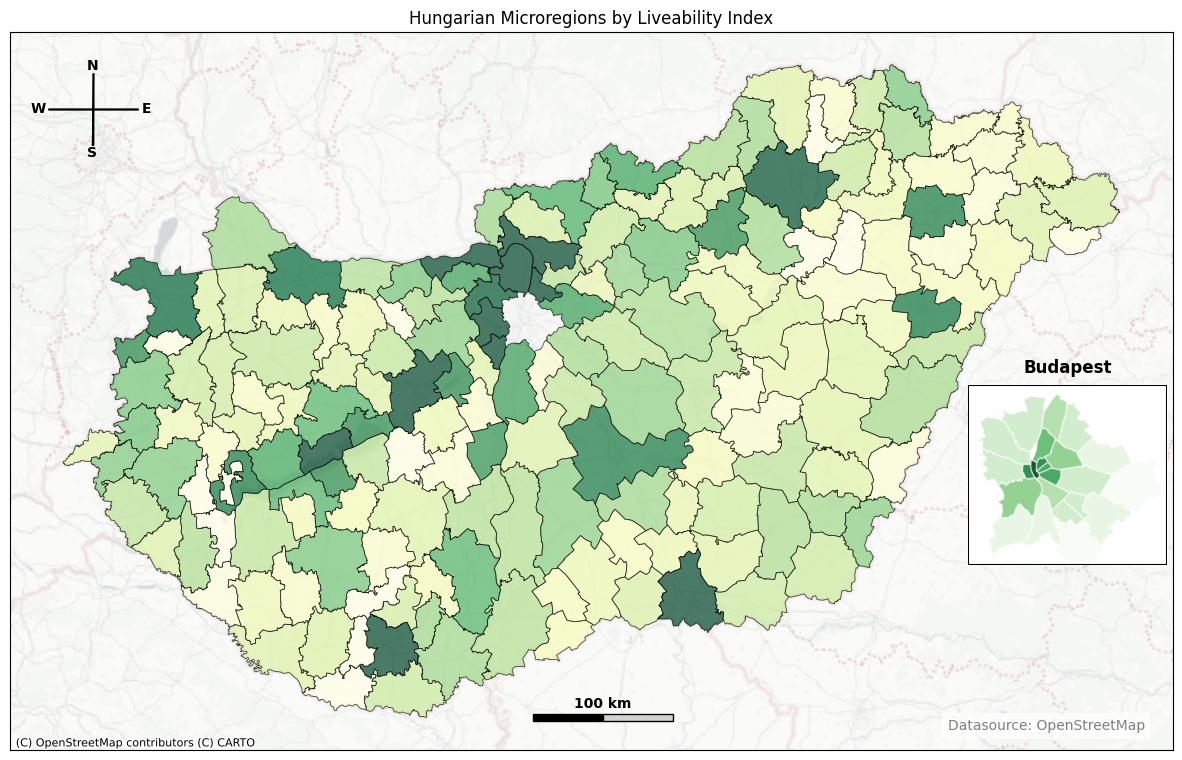

In [12]:
# Plot results
fig, ax = plt.subplots(figsize=(15, 12))
regions_df['geometry'] = regions_df['Name'].apply(lambda x: gpd.read_file(f"{save_dir}/{x}_boundary.geojson").geometry.iloc[0])
regions_gdf = gpd.GeoDataFrame(regions_df, geometry=regions_df['geometry']).set_crs(epsg=4326).to_crs(crs_projected)

# Create color map based on liveability index
norm = mcolors.Normalize(vmin=regions_gdf['Liveability index'].quantile(0.05), 
                         vmax=regions_gdf['Liveability index'].quantile(0.95))

cmap = plt.get_cmap('YlGn')
colors = regions_gdf['Liveability index'].apply(lambda x: cmap(norm(x)))

# Plot regions with color mapped to liveability index
regions_gdf.plot(ax=ax, color=colors, edgecolor='k', alpha=0.7, linewidth=0.6)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
plt.title("Hungarian Microregions by Liveability Index")
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add compass
draw_compass(ax)

# Add Budapest image
add_image('Budapest.png')

# Add scale bar
add_scale_bar(ax)

# Add text
fig.text(0.75, 0.21, "Datasource: OpenStreetMap", fontsize=10, va='bottom', color='gray', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.savefig('Hungarian Microregions by Liveability Index.png', dpi=300, bbox_inches='tight')
plt.show()